# Test the ReadSTAC class

In this Notebook, the methods of the ReadSTAC class are explored and tested. 

The main purposes and functions of the class are: 
1. Read a STAC API to obtain metadata
2. Download data using the ``stackstac`` library, allowing for direct further processing of the data as ``xarray.DataArray`` objects. With this approach, a small area of interest can be defined before downloading the data, making it more efficient and faster than downloading whole tiles. 
3. Downloading whole tiles as GeoTIFFs and VRTs. 

## Setup

In [1]:
import sys
sys.path.append('..')
from src.data.get_satellite_images import ReadSTAC

import matplotlib.pyplot as plt
import skimage

## 1. Read STAC API to obtain metadata

In [6]:
# Option 1 (Default): Read from Planetary Computer STAC API
api_url="https://planetarycomputer.microsoft.com/api/stac/v1"
bands = ['B04', 'B03', 'B02']
bands_landsat = ['red', 'green', 'blue']

# # Option 2: Read from AWS STAC API
# api_url="https://earth-search.aws.element84.com/v1"
# bands = ['red', 'green', 'blue']

stac_reader = ReadSTAC(api_url=api_url, collection = "landsat-c2-l2")

# check available items
items = stac_reader.get_items(
    location = [-50.18255000697929, -6.054643555224412],
    buffer=10,
    timerange='2020-01-01/2020-12-30',
    max_cloud_cover=10
)
items

9 Items found.


Loading a particular item, either the least cloudy or the most recent in the area of interest:

In [7]:
least_cloudy_item = stac_reader.filter_item(items, "least_cloudy")
most_recent_item = stac_reader.filter_item(items, "most_recent")

Found 1 unique tile ids.
Choosing the best 1 items.For unique tile 224_064, choosing ['LE07_L2SP_224064_20200814_02_T1'] from [datetime.date(2020, 8, 14)] with [0.0]% cloud cover
Found 1 unique tile ids.
Choosing the best 1 items.For unique tile 224_064, choosing ['LE07_L2SP_224064_20200915_02_T1'] from [datetime.date(2020, 9, 15)] with [1.0]% cloud cover


Preview the tile: 

In [4]:
# table, image = stac_reader.preview_item(least_cloudy_item[0])
# display(table)
# image.show()

## 2. Downloading data using the stackstac library
The stackstac library facilitates lazy-load, i.e. the data is only loaded at the end when requested. 

### Get the stack item of only the area of interest defined in the class above

In [12]:
stack = stac_reader.get_stack(items, filter_by="least_cloudy", bands=bands_landsat, resolution=10, take_best_n=3)
stack

Loading stack...
Found 1 unique tile ids.
Choosing the best 3 items.For unique tile 224_064, choosing ['LE07_L2SP_224064_20200814_02_T1', 'LE07_L2SP_224064_20200713_02_T1', 'LC08_L2SP_224064_20200705_02_T1'] from [datetime.date(2020, 8, 14), datetime.date(2020, 7, 13), datetime.date(2020, 7, 5)] with [0.0, 0.0, 0.0]% cloud cover


/opt/venv/lib/python3.12/site-packages/stackstac/prepare.py:408: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-0e834aa67f94ce8835b80fbe3ff6c200' (band: 3,
                                                                y: 1990, x: 2009)> Size: 96MB
dask.array<mosaic-aggregate, shape=(3, 1990, 2009), dtype=float64, chunksize=(1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/19)
  * band                         (band) <U5 60B 'red' 'green' 'blue'
  * x                            (x) float64 16kB 5.804e+05 ... 6.005e+05
  * y                            (y) float64 16kB -6.594e+05 ... -6.792e+05
    landsat:collection_category  <U2 8B 'T1'
    eo:cloud_cover               float64 8B 0.0
    landsat:collection_number    <U2 8B '02'
    ...                           ...
    proj:epsg                    int64 8B 32622
    unique_tile_identifier       <U7 28B '224_064'
    view:off_nadir               int64 8B 0
    title                        (band) <U10 120B 'Red Band' ... 'Blue Band'
    raster:bands                 object 8B {'scale': 2.75e-05, 'nodata': 0, '...
    epsg                         int64 8B 32622
Attributes:
    spec:        RasterSpec(epsg=32622, bounds=(580420, -679260, 600510, -659...
    crs:         epsg:32622
    transform:   | 10.00, 0.00, 580420.00|\n| 0.00,-10.00,-659360.00|\n| 0.00...
    resolution:  10

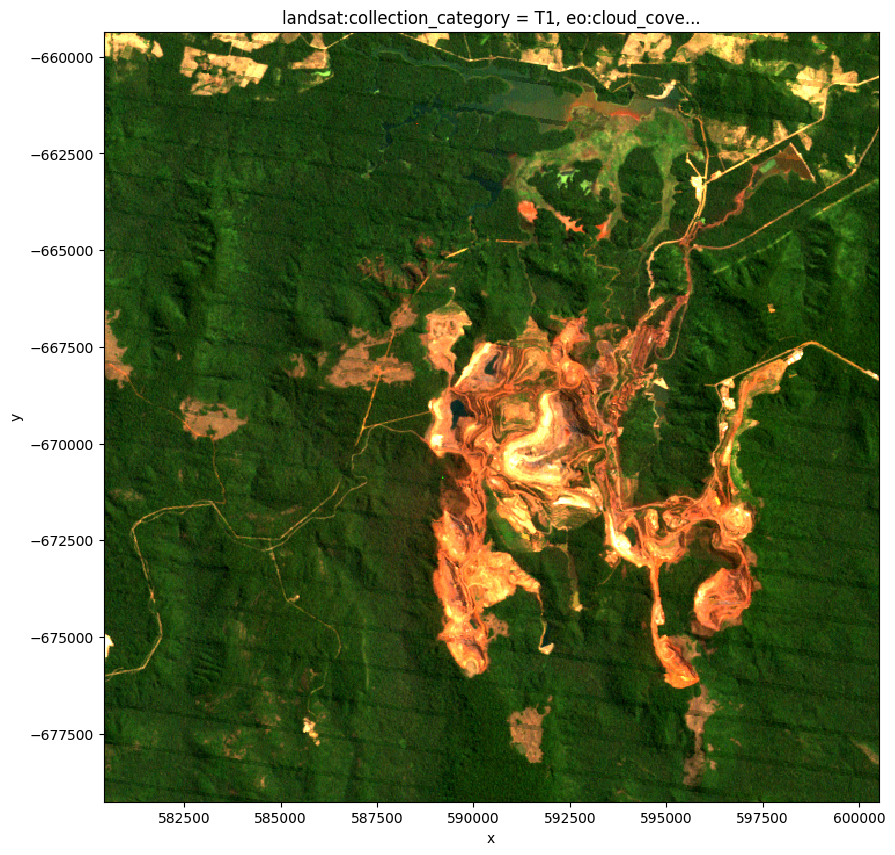

In [13]:
stac_reader.display_stack_as_image(stack)

### Enhance contrast with contrast stretching

In [8]:
stack_stretched = stac_reader.stretch_contrast_stack(stack)

In [ ]:
stac_reader.display_stack_as_image(stack_stretched)

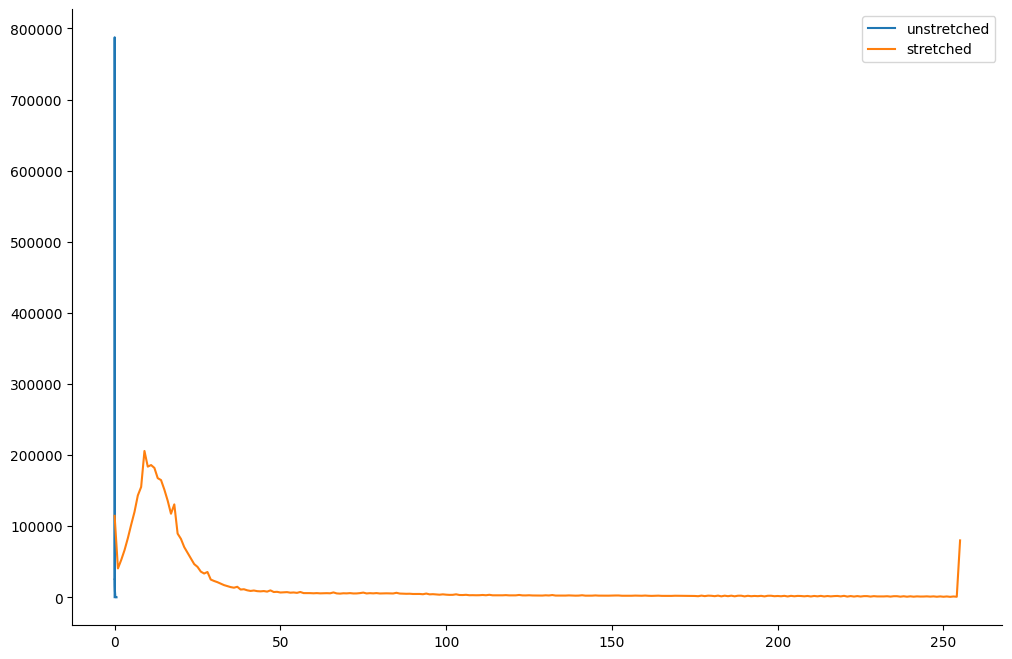

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))

hist, bins = skimage.exposure.histogram(stack.isel(band=0).data.compute())
ax.plot(bins, hist, label="unstretched")

hist, bins = skimage.exposure.histogram(stack_stretched.isel(band=0).data)
ax.plot(bins, hist, label="stretched")

plt.legend()
sns.despine()

We can now save the stack as a GeoTIFF, to be used further downstream. 

In [6]:
stac_reader.save_stack_as_geotiff(stack_stretched)

Saved stack as GeoTIFF: /workspaces/mine-segmentation/src/data/temp/S2A_22MEU_20210629_0_L2A.tif


## 3. Download full images 
We can download one band: 

In [6]:
path = stac_reader.download_band(
    item=least_cloudy_item, 
    band_name="blue",
    band_key="blue",
    )
path

File /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_blue.tif already exists, skipping download.


'/workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_blue.tif'

we can save one or multiple GeoTIFF files as VRTs: 

In [7]:
stack = stac_reader.tif_to_vrt(least_cloudy_item.id, [path])

Created VRT: /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A.vrt


ERROR 1: Zero positional arguments expected


In [4]:
stac_reader.download_item_as_vrt(
    item=least_cloudy_item,
    bands_to_download={"blue": "blue", "green": "green", "red": "red"}
)

File /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_blue.tif already exists, skipping download.
File /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_green.tif already exists, skipping download.
File /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_red.tif already exists, skipping download.


ERROR 1: Zero positional arguments expected
/usr/lib/python3/dist-packages/osgeo/gdal.py:311: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


Created VRT: /workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A.vrt


'/workspaces/mine-segmentation/src/data/temp/S2A_32PPR_20210114_1_L2A_stretched.tif'